In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, QiskitError
#from qiskit import execute, BasicAer
import qiskit.ignis.verification.randomized_benchmarking as rb
#import qiskit.test.benchmarks.randomized_benchmarking as br
import pyzx
from pyzx.circuit.qasmparser import QASMParser
from pyzx.circuit.qiskitqasmparser import QiskitQASMParser

In [107]:
#qc = rb.randomized_benchmarking_seq()
qc = rb.randomized_benchmarking_seq(nseeds=1, length_vector=None,
                                rb_pattern=[[0,1]],
                                length_multiplier=1, seed_offset=0,
                                align_cliffs=False,
                                interleaved_gates=None,
                                is_purity=False)
qc = qc[0][0][0]

In [108]:
# setting up the backend
# print(BasicAer.backends())

# running the job
# job_sim = execute(qc, BasicAer.get_backend('qasm_simulator'))
# sim_result = job_sim.result()

In [109]:
# print("\nPrint all gates:")
# [print(dat) for dat in qc.data]

In [110]:
qasm = qc.qasm()
### if you want to remove all barriers
## qasm = '\n'.join(['' if line.startswith("barrier") else line for line in qasm.splitlines()])

qc = qc.from_qasm_str(qasm)

print("\nPrint QASM:")
print(qasm)


Print QASM:
OPENQASM 2.0;
include "qelib1.inc";
qreg qr[2];
creg cr[2];
h qr[1];
cx qr[0],qr[1];
h qr[0];
s qr[0];
x qr[1];
barrier qr[0],qr[1];
x qr[1];
sdg qr[0];
h qr[0];
cx qr[0],qr[1];
h qr[1];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];



In [111]:
# Draw the circuit
print(qc)

                   ┌───┐┌───┐ ░ ┌─────┐┌───┐     ┌─┐        
qr_0: |0>───────■──┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├──■──┤M├────────
         ┌───┐┌─┴─┐├───┤└───┘ ░ └┬───┬┘└───┘┌─┴─┐└╥┘┌───┐┌─┐
qr_1: |0>┤ H ├┤ X ├┤ X ├──────░──┤ X ├──────┤ X ├─╫─┤ H ├┤M├
         └───┘└───┘└───┘      ░  └───┘      └───┘ ║ └───┘└╥┘
 cr_0: 0 ═════════════════════════════════════════╩═══════╬═
                                                          ║ 
 cr_1: 0 ═════════════════════════════════════════════════╩═
                                                            


In [112]:
p = QiskitQASMParser()
circ_list, whichpyzx = p.qiskitparse(qasm)
print(circ_list)
print(whichpyzx)
print(p.registers)

['qreg qr[2];', 'creg cr[2];', Circuit(2 qubits, 5 gates), 'barrier qr[0],qr[1];', Circuit(2 qubits, 5 gates), 'measure qr[0] -> cr[0];', 'measure qr[1] -> cr[1];']
[2, 4]
{'qr': (0, 2)}


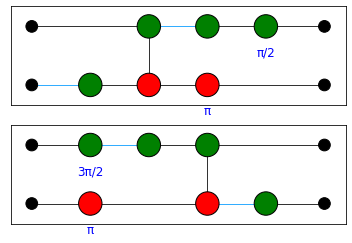

In [113]:
#qasm = qc.decompose().qasm()
pyzx.draw_many(circ_list, whichpyzx)

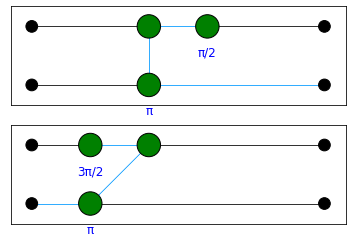

In [114]:
graph_list = [circ_list[w].to_graph() for w in whichpyzx]
[pyzx.full_reduce(g) for g in graph_list]
pyzx.draw_many(graph_list, range(len(whichpyzx)))

In [115]:
pyzx_circ_list = [pyzx.extract.streaming_extract(g) for g in graph_list]

for i in range(len(pyzx_circ_list)):
    prev = pyzx_circ_list[i]
    next = pyzx.extract.streaming_extract(graph_list[i])
    while prev.gates != next.gates:
        for j in range(len(next.gates))[::-1]:
            pyzx_circ_list[i].add_gate_to_front(next.gates[j])
        prev = next
        next = pyzx.extract.streaming_extract(graph_list[i])

pyzx_circ_list = [pyzx.optimize.basic_optimization(new_c.to_basic_gates()) for new_c in pyzx_circ_list]

pyzx_qasm = [new_c.to_basic_gates().to_qasm() for new_c in pyzx_circ_list]

passedAll = True
for i in range(len(pyzx_circ_list)):
    try:
        assert(pyzx.compare_tensors(pyzx_circ_list[i], circ_list[whichpyzx[i]]))
    except AssertionError:
        print(i)
        print(circ_list[whichpyzx[i]].__dict__)
        print(pyzx_circ_list[i].__dict__)
        passedAll = False
assert(passedAll)

In [116]:
pyzx_qasm = ["\n".join(['' if line.startswith("qreg") else line for line in circ.splitlines()[2:]]) for circ in pyzx_qasm]

for new_qasm in pyzx_qasm:
    [print(line) for line in new_qasm.splitlines()]
    print()


cz q[0], q[1];
h q[1];
h q[0];
rz(0.5*pi) q[0];
x q[1];


rz(1.5*pi) q[0];
h q[0];
h q[1];
cz q[0], q[1];
z q[1];



In [117]:
#now we need to map registers and glue all the pieces back together
for i in range(len(pyzx_qasm)):
    circ_list[whichpyzx[i]] = pyzx_qasm[i]
#print(circ_list)
## join the
qasm_string = 'OPENQASM 2.0;\ninclude "qelib1.inc";\n'+"\n".join(circ_list)
qasm_string = qasm_string.replace('q[', 'qr[')
print(qasm_string)

OPENQASM 2.0;
include "qelib1.inc";
qreg qr[2];
creg cr[2];

cz qr[0], qr[1];
h qr[1];
h qr[0];
rz(0.5*pi) qr[0];
x qr[1];
barrier qr[0],qr[1];

rz(1.5*pi) qr[0];
h qr[0];
h qr[1];
cz qr[0], qr[1];
z qr[1];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];


In [118]:
# pqsl = [line + "\n" for line in pyzx_qasm] #took out .splitlines()
# qsl = [line + "\n" for line in qasm.splitlines()]
# # print(pqsl)
# # print(qsl)
# new_qasm = '\n'.join(qsl[0:4]) + ''.join(pqsl[3:]) + ''.join(qsl[-2:])
# new_qasm = new_qasm.replace('q[', 'qr[')
# print(new_qasm)

In [119]:
new_qc = qc.from_qasm_str(qasm_string)
print(new_qc)

            ┌───┐┌────────────┐ ░ ┌────────────┐┌───┐   ┌─┐        
qr_0: |0>─■─┤ H ├┤ Rz(0.5*pi) ├─░─┤ Rz(1.5*pi) ├┤ H ├─■─┤M├────────
          │ ├───┤└───┬───┬────┘ ░ └───┬───┬────┘└───┘ │ └╥┘┌───┐┌─┐
qr_1: |0>─■─┤ H ├────┤ X ├──────░─────┤ H ├───────────■──╫─┤ Z ├┤M├
            └───┘    └───┘      ░     └───┘              ║ └───┘└╥┘
 cr_0: 0 ════════════════════════════════════════════════╩═══════╬═
                                                                 ║ 
 cr_1: 0 ════════════════════════════════════════════════════════╩═
                                                                   


In [120]:
print(qc)

                   ┌───┐┌───┐ ░ ┌─────┐┌───┐     ┌─┐        
qr_0: |0>───────■──┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├──■──┤M├────────
         ┌───┐┌─┴─┐├───┤└───┘ ░ └┬───┬┘└───┘┌─┴─┐└╥┘┌───┐┌─┐
qr_1: |0>┤ H ├┤ X ├┤ X ├──────░──┤ X ├──────┤ X ├─╫─┤ H ├┤M├
         └───┘└───┘└───┘      ░  └───┘      └───┘ ║ └───┘└╥┘
 cr_0: 0 ═════════════════════════════════════════╩═══════╬═
                                                          ║ 
 cr_1: 0 ═════════════════════════════════════════════════╩═
                                                            


In [121]:
import qiskit
from qiskit.providers.basicaer import QasmSimulatorPy
c1 = qiskit.execute(qc, QasmSimulatorPy()).result().get_counts()
c2 = qiskit.execute(new_qc, QasmSimulatorPy()).result().get_counts()

In [122]:
c1
c2
assert(c1 == c2)

In [123]:
qiskit_transpiled_qc = qiskit.transpile(qc, basis_gates=['u3', 'cx'], optimization_level=2)

In [124]:
print(qiskit_transpiled_qc)

                          ┌──────────────────┐ ░  ┌────────────┐     ┌─┐»
qr_0: |0>──────────────■──┤ U3(pi/2,pi/2,pi) ├─░──┤ U2(0,pi/2) ├──■──┤M├»
         ┌──────────┐┌─┴─┐└─┬─────────────┬──┘ ░ ┌┴────────────┤┌─┴─┐└╥┘»
qr_1: |0>┤ U2(0,pi) ├┤ X ├──┤ U3(pi,0,pi) ├────░─┤ U3(pi,0,pi) ├┤ X ├─╫─»
         └──────────┘└───┘  └─────────────┘    ░ └─────────────┘└───┘ ║ »
 cr_0: 0 ═════════════════════════════════════════════════════════════╩═»
                                                                        »
 cr_1: 0 ═══════════════════════════════════════════════════════════════»
                                                                        »
«                     
«qr_0: ───────────────
«      ┌──────────┐┌─┐
«qr_1: ┤ U2(0,pi) ├┤M├
«      └──────────┘└╥┘
«cr_0: ═════════════╬═
«                   ║ 
«cr_1: ═════════════╩═
«                     


In [125]:
pyzx_then_qiskit_qc = qiskit.transpile(new_qc, basis_gates=['u3', 'cx'], optimization_level=2)
print(pyzx_then_qiskit_qc)

                          ┌──────────────────┐ ░ ┌─────────────┐     ┌─┐»
qr_0: |0>──────────────■──┤ U3(pi/2,pi/2,pi) ├─░─┤ U2(0,5pi/2) ├──■──┤M├»
         ┌──────────┐┌─┴─┐└─┬─────────────┬──┘ ░ └─────────────┘┌─┴─┐└╥┘»
qr_1: |0>┤ U2(0,pi) ├┤ X ├──┤ U3(pi,0,pi) ├────░────────────────┤ X ├─╫─»
         └──────────┘└───┘  └─────────────┘    ░                └───┘ ║ »
 cr_0: 0 ═════════════════════════════════════════════════════════════╩═»
                                                                        »
 cr_1: 0 ═══════════════════════════════════════════════════════════════»
                                                                        »
«                           
«qr_0: ─────────────────────
«      ┌────────────────┐┌─┐
«qr_1: ┤ U3(pi/2,pi,pi) ├┤M├
«      └────────────────┘└╥┘
«cr_0: ═══════════════════╬═
«                         ║ 
«cr_1: ═══════════════════╩═
«                           


In [126]:
AllCircuits = {"QC_Original": qc, "QC_pyZX": new_qc, "QC_QiskitTranspiler": qiskit_transpiled_qc, "QC_Both": pyzx_then_qiskit_qc}
OutputDict = {}

if passedAll == False:
    print("reject this sample")
else:
    for key, value in AllCircuits.items():
        OutputDict[key]= {"Depth":value.depth(), "Size":value.size()}
    Metrics = ["Depth", "Size"]
print(OutputDict)


{'QC_Original': {'Depth': 9, 'Size': 12}, 'QC_pyZX': {'Depth': 8, 'Size': 12}, 'QC_QiskitTranspiler': {'Depth': 7, 'Size': 10}, 'QC_Both': {'Depth': 7, 'Size': 9}}


In [127]:
import numpy as np
import matplotlib.pyplot as plt

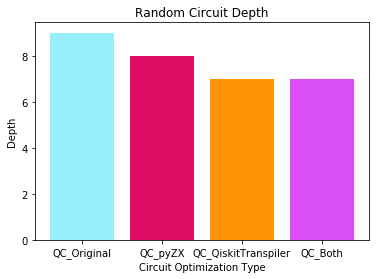

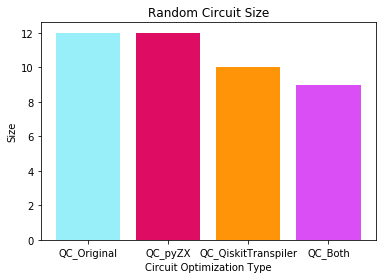

In [129]:
for metric in Metrics:
    plt.title("Random Circuit " + metric)
    plt.bar(range(len(AllCircuits)), [OutputDict[circ][metric] for circ in AllCircuits] , 
            align='center', color = ["xkcd:robin's egg blue", "xkcd:cerise", "xkcd:tangerine", "xkcd:heliotrope"])
    plt.xticks(range(len(AllCircuits)), list(AllCircuits.keys()))
    plt.xlabel("Circuit Optimization Type")
    plt.ylabel(metric)
    plt.show()